In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
# Concating the 2 DF of web scraped Alex properties with the 2 DF of web scraped Cairo properties
df1=pd.read_excel(r'C:\Users\HP\Downloads\program files\property_finder_data_cairo.xlsx')
df2 = pd.read_excel(r'C:\Users\HP\Downloads\program files\property_finder_data_cairo2.xlsx')
df3=pd.read_excel(r'C:\Users\HP\Downloads\program files\property_finder_data_2.xlsx')
df4 = pd.read_excel(r'C:\Users\HP\Downloads\program files\property_finder_data.xlsx')
dfa = pd.concat([df1, df2], ignore_index=True)
dfc = pd.concat([df3, df4], ignore_index=True)
df = pd.concat([dfa, dfc], ignore_index=True)

In [3]:
df.head()

,Property_type,Price,Area,Location,Date_listed,#bedrooms,#bathrooms,Telephone
0,Apartment,"5,500,000 EGP",225 sqm,"Promenade New Cairo, 5th Settlement Compounds,...",Listed 11 hours ago,3,3,tel:+201110003716
1,Duplex,"5,390,000 EGP",146 sqm,"TRIO, 5th Settlement Compounds, The 5th Settle...",Listed 1 month ago,2,3,tel:+201144445606
2,Apartment,"16,000,000 EGP",190 sqm,"El Patio Vida, The 6th Settlement, New Cairo C...",Listed 5 hours ago,3,3,tel:+20221257009
3,Apartment,"5,400,000 EGP",140 sqm,"Mountain View iCity, 5th Settlement Compounds,...",Listed 5 hours ago,2,2,tel:+20221208148
4,Apartment,"7,500,000 EGP",185 sqm,"Palm Hills New Cairo, 5th Settlement Compounds...",Listed 1 month ago,3,3,tel:+20221208148


In [4]:
df.shape

(4911, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4911 entries, 0 to 4910
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Property_type  4911 non-null   object
 1   Price          4911 non-null   object
 2   Area           4911 non-null   object
 3   Location       4911 non-null   object
 4   Date_listed    4911 non-null   object
 5   #bedrooms      4911 non-null   object
 6   #bathrooms     4911 non-null   object
 7   Telephone      4911 non-null   object
dtypes: object(8)
memory usage: 307.1+ KB


In [6]:
# Adjusting the price column 
df['Price'] = df['Price'].str.replace('EGP','',regex=False)
df['Price'] = df['Price'].str.replace(',','',regex=False)
df = df[df['Price'] != 'Ask for price']
df['Price'] = pd.to_numeric(df['Price'])

In [7]:
# Adjusting the Area column
df['Area'] = df['Area'].str.replace(',', '').str.strip()
df['Area'] = df['Area'].str.replace('sqm','',regex=False)
df['Area'] = pd.to_numeric(df['Area'])

In [8]:
# Adjusting the Date Listed column
df['Date_listed'] = df['Date_listed'].str.replace('more than','')
def get_month(text):
    today = datetime.today()
    num = int(text.split()[1])
    
    if 'minute' in text:
        date = today - timedelta(minutes=num)
    elif 'hour' in text:
        date = today - timedelta(hours=num)
    elif 'day' in text:
        date = today - timedelta(days=num)
        
    elif 'month' in text:
        date = today - pd.DateOffset(months=num)
        
    else:
        return None
    
    return date.strftime('%B')

df['listed_month'] = df['Date_listed'].apply(get_month)   

In [9]:
# Adjusting the Telephone column
df['Telephone'] = df['Telephone'].str.replace('tel:+2','')


In [10]:
# Adjust rooms columns , when rooms more than 7 it written in the web as 7+ that making issues in converting the column to numeric
df = df[df['#bedrooms'] != 'studio']
df['#bathrooms'] = df['#bathrooms'].str.replace('7+','7')
df['#bedrooms'] = df['#bedrooms'].str.replace('7+','7')
df['#bedrooms'] = pd.to_numeric(df['#bedrooms'])
df['#bathrooms'] = pd.to_numeric(df['#bathrooms'])

In [11]:
df_split = df['Location'].str.split(',', expand=True)

# Rename columns dynamically based on the number of splits
# Because for example when i put 3 columm name it tells me that some values are 4 elements 
# So it determine the number of columns for each row 
df_split.columns = [f'Part_{i+1}' for i in range(df_split.shape[1])]

df_split = df_split.applymap(lambda x: np.nan if x is None else x)

# Replace NaN in Part_5 with values from Part_4
df_split['Part_5'] = df_split['Part_5'].fillna(df_split['Part_4']).fillna(df_split['Part_3'])
# Join the split columns back into the original dataframe
df = df.join(df_split)


C:\Users\HP\AppData\Local\Temp\ipykernel_2596\379051832.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_split = df_split.applymap(lambda x: np.nan if x is None else x)


In [12]:
# Remove unwanted columns
df= df.drop(columns=['Part_4','Location','Date_listed'])

In [13]:
df['Part_3'] = df['Part_3'].fillna(df['Part_3'].mode()[0])
df['Part_3'] = df['Part_3'].str.replace(' Alexandria',' Alexandria Compounds')
df['Part_2'] = df['Part_2'].str.strip()
df['Part_3'] = df['Part_3'].str.strip()

In [14]:
# Add Three important columns
df['Total_rooms'] = df['#bathrooms'] + df['#bedrooms']
df['Price per sqm'] = ((df['Price'] / df['Area'])).round(2).astype(float)
df['Price per Room'] = (df['Price'] / df['Total_rooms']).round(2).astype(float)
df['Price'] = df['Price'].astype(float).round(1)

In [15]:
# Renaming the columns
df.columns = ['Property_type','Price','Area_in_sqm','Bedrooms',
              'Bathrooms','Telephone','Listed_Month','Street',
              'Region','EL_Hay','City','Total_rooms','Price_per_sqm','Price_per_room']

In [16]:
df.head(2)

,Property_type,Price,Area_in_sqm,Bedrooms,Bathrooms,Telephone,Listed_Month,Street,Region,EL_Hay,City,Total_rooms,Price_per_sqm,Price_per_room
0,Apartment,"5,500,000.00",225,3,3,01110003716,April,Promenade New Cairo,5th Settlement Compounds,The 5th Settlement,Cairo,6,"24,444.44","916,666.67"
1,Duplex,"5,390,000.00",146,2,3,01144445606,March,TRIO,5th Settlement Compounds,The 5th Settlement,Cairo,5,"36,917.81","1,078,000.00"


In [17]:
# Saving the file after all adjustments
df.to_excel('property_finder_combined_3.xlsx', index=False, engine='openpyxl')

In [18]:
df.groupby(['City'])['Price'].max().sort_values()

City
Cairo        250,000,000.00
Alexandria   333,300,000.00
Name: Price, dtype: float64

In [19]:
df['City'].value_counts()

City
Alexandria    2384
Cairo         2349
Name: count, dtype: int64

<Axes: title={'center': 'Property Types Distribution'}, xlabel='Property_type'>

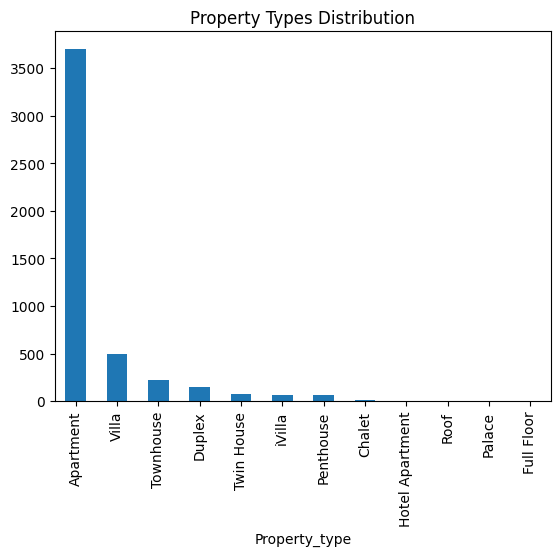

In [20]:
df['Property_type'].value_counts().plot(kind='bar', title='Property Types Distribution')

<Axes: title={'center': 'Avg Price per Property Type'}, ylabel='Property_type'>

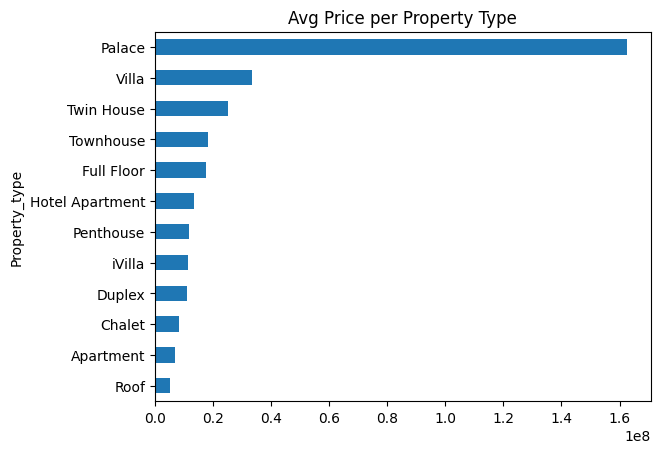

In [21]:
df.groupby('Property_type')['Price'].mean().sort_values().plot(kind='barh', title='Avg Price per Property Type')

<Axes: xlabel='Total_rooms', ylabel='Price'>

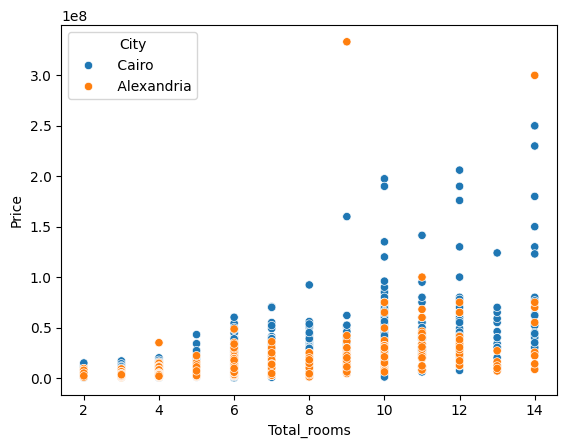

In [22]:
sns.scatterplot(data=df, x='Total_rooms', y='Price', hue='City')

<Axes: title={'center': 'Properties per City'}, ylabel='count'>

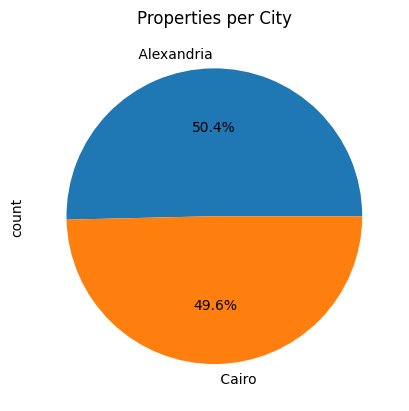

In [23]:
df['City'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Properties per City')


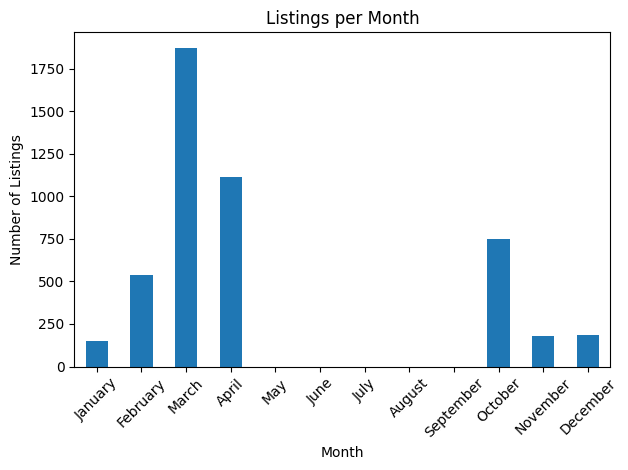

In [24]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Listed_Month'] = pd.Categorical(df['Listed_Month'], categories=month_order, ordered=True)

df['Listed_Month'].value_counts(sort=False).plot(kind='bar', title='Listings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Price Prediction #

Importing essential modules for performing the prediction

In [25]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import stats

As you can see there are outliers this will affect our model and will reduce the accuracy

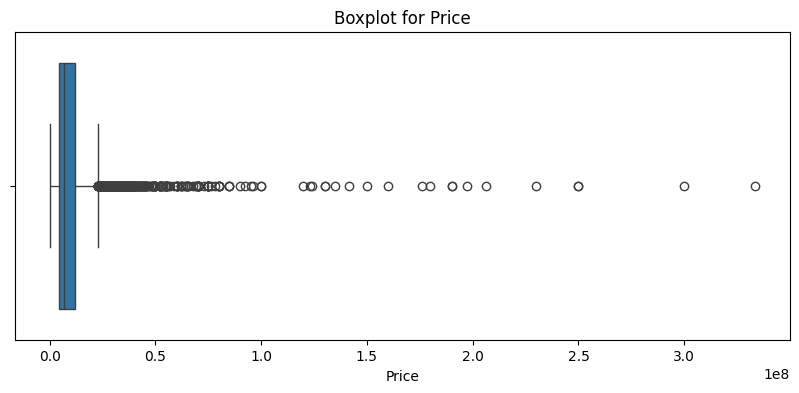

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Price'])
plt.title('Boxplot for Price')
plt.show()

In [27]:
# Removing top 5% of price data 
price_threshold = df['Price'].quantile(0.95)
df = df[df['Price'] < price_threshold]

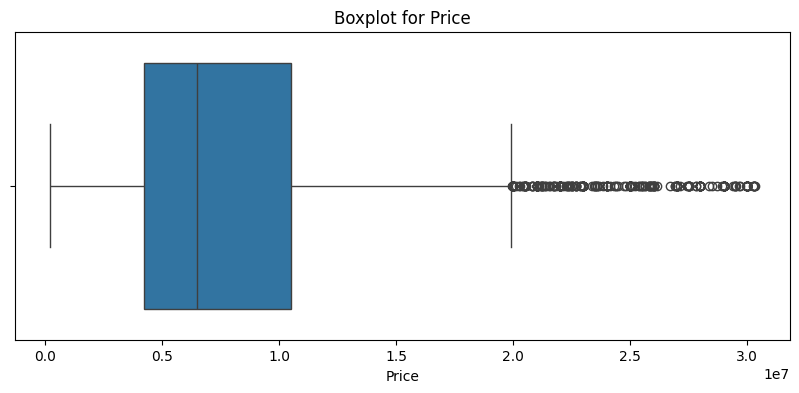

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Price'])
plt.title('Boxplot for Price')
plt.show()

Select Features (X) and Target (y)

we are predicting the price so the price is the target

In [29]:
y = df['Price']
X = df[['Property_type','Area_in_sqm','Listed_Month','City', 'Total_rooms', 'Price_per_sqm','Price_per_room']]

Perform one-hot encoding for Categorical Variables (Here i have used the one hot encoding in Pandas)

In [30]:
X = pd.get_dummies(X, columns=['Property_type','Listed_Month','City'], drop_first=True)

You see the different variance or scale of each column that will affect our model very badly , so the solution is to perform feature scalling

In [31]:
X.describe()

,Area_in_sqm,Total_rooms,Price_per_sqm,Price_per_room
count,"4,549.00","4,549.00","4,549.00","4,549.00"
mean,"4,368.94",5.48,"43,717.64","1,479,219.37"
std,"281,702.87",1.68,"25,311.69","851,159.95"
min,25.00,2.00,1.00,"33,333.33"
25%,140.00,4.00,"25,617.28","875,000.00"
50%,170.00,5.00,"36,931.82","1,250,000.00"
75%,217.00,6.00,"55,384.62","1,904,962.86"
max,"19,000,000.00",14.00,"350,000.00","7,450,000.00"


In [32]:
scaler = StandardScaler()
scaler.fit_transform(X)

array([[-0.01471192,  0.30897761, -0.76151835, ..., -0.20356259,
        -0.20179927,  1.05445951],
       [-0.01499239, -0.28583371, -0.26867333, ..., -0.20356259,
        -0.20179927,  1.05445951],
       [-0.01483618,  0.30897761,  1.59994608, ..., -0.20356259,
        -0.20179927,  1.05445951],
       ...,
       [-0.01474743,  0.30897761, -0.67984   , ..., -0.20356259,
         4.95541923, -0.94835315],
       [-0.01481843,  0.30897761,  0.19757117, ..., -0.20356259,
         4.95541923, -0.94835315],
       [-0.01451666,  0.90378893,  0.17767067, ..., -0.20356259,
         4.95541923, -0.94835315]], shape=(4549, 26))

splitting the data into train(80%) and test (20%)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create Linear Regression Model and Train it

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Predict and Evalute

In [35]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Square Error:", round(mse, 2))
print('RMSE',round(rmse, 2))

average_price = y.mean()
relative_error = ((rmse / average_price)*100).round(2)
print("Relative Error: ",relative_error , '%')

Mean Square Error: 1933818810095.77
RMSE 1390618.14
Relative Error:  16.75 %
